In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
datos = pd.read_csv('../datasets/netflix_customer_churn.csv')
datos.head(5)

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [5]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

In [6]:
#Eliminacion filas duplicadas
datos = datos.drop_duplicates()

In [7]:
#Eliminacion de nulos
datos = datos.replace(["", " ", "NA", "N/A"], np.nan)

In [8]:
#verificar si hay valores nulos
datos.isnull().sum()

customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [9]:
#separar columnas numericas y categoricas
numeric_cols = datos.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = datos.select_dtypes(include="object").columns

In [10]:
#coumnas numericas -> mediana
for col in numeric_cols:
    datos[col] = datos[col].fillna(datos[col].median())

In [11]:
#columna categoricas -> moda
for col in categorical_cols:
    datos[col] = datos[col].fillna(datos[col].mode()[0])

In [12]:
#cambiar categorical por category
datos[categorical_cols] = datos[categorical_cols].astype("category")

In [13]:
#verificacion final
datos.info()

datos.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   customer_id             5000 non-null   category
 1   age                     5000 non-null   int64   
 2   gender                  5000 non-null   category
 3   subscription_type       5000 non-null   category
 4   watch_hours             5000 non-null   float64 
 5   last_login_days         5000 non-null   int64   
 6   region                  5000 non-null   category
 7   device                  5000 non-null   category
 8   monthly_fee             5000 non-null   float64 
 9   churned                 5000 non-null   int64   
 10  payment_method          5000 non-null   category
 11  number_of_profiles      5000 non-null   int64   
 12  avg_watch_time_per_day  5000 non-null   float64 
 13  favorite_genre          5000 non-null   category
dtypes: category(7), float64(

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [14]:
datos.isnull().sum()

customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [15]:
categorical_cols[1:]

Index(['gender', 'subscription_type', 'region', 'device', 'payment_method',
       'favorite_genre'],
      dtype='object')

In [ ]:
def graficar_categoricas(df,categorias:list):
    rows = len(categorias)
    cols = len(df['churned'].unique())

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    fig.suptitle('Comportamiento de variables categóricas', fontsize=16)

    label_colors = {
    'Male': '#16537e',
    'Female': '#ff8383',
    'Si': '#66bb6a',  # green
    'No': '#ef5350',  # red
    'Basic': '#e69138',
    'Premium': '#6aa84f',
    'Standard': '#ff0054',
    'Oceania': "#a8dadc",  # Pale cyan
    'Asia': "#f7ede2",  # Cream
    'Africa': '#33FF33', # Verde puro
    'North America': '#338DFF',
    'Tablet': '#2E2E2E', # Gris oscuro
    'TV': "#f5cac3",  # Blush pink
    'Laptop':"#84a59d",  # Muted green
    'Europe': '#48aac0',
    'Mobile': '#3eb99d',
    'Crypto': '#FF5733', # Rojo anaranjado
    'Credit Card': '#33FF57', # Verde brillante
    'Debit Card': '#338DFF', 
    'PayPal': '#FF33A8', # Rosa fuerte
    'Gift Card': '#A833FF', # Morado
    'Drama': '#33FFF3', # Turquesa
    'Sci-Fi': '#FFC733', # Amarillo
    'Comedy': '#FF8F33', # Naranja
    'Romance': '#8DFF33', # Verde menta
    'Action': '#338DFF', # Azul cielo
    'Horror': '#8D33FF', # Violeta
    'Documentary': '#FF3333' # Rojo puro
    }

    for i, col in enumerate(categorias):
      for j, status in enumerate(df['churned'].unique()):

        sub_df = df[df['churned'] == status]
        counts = sub_df[col].value_counts()
        labels = ['Si' if val == 1 else 'No' if val == 0
                  else str(val) for val in counts.index]
        colors = [label_colors.get(label, '#cccccc') for label in labels]  # Color Default
        axs[i, j].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90,colors=colors)
        axs[i, j].set_title(f'Cuentas {"activas" if status == 0 else "canceladas"} por {col.replace("_", " ").capitalize()}',
                            fontsize = 14)
        #axs[i, j].axis('equal')

    # Borra el espacio no usado
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    fig.show()

    #fig.savefig('/content/GraficasCategoricas.png',transparent=False, dpi = 300, bbox_inches = 'tight')

    return

def graficar_numericas(df,numericas:list):
  for col in numericas:

    if col == 'churned':
      continue

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    sns.boxplot(data=df, y=col, hue='churned',ax=axes[0])
    axes[0].set_title(f'Comparativa {col.replace("_", " ").capitalize()}',fontsize = 12)
    axes[0].legend(['Activas', 'Canceladas'],title='Cuentas', loc='upper left', bbox_to_anchor=(1, 1))

    sns.kdeplot(data=df[df['churned'] == 0], x=col, label='Activas', fill=True, ax=axes[1])
    sns.kdeplot(data=df[df['churned'] == 1], x=col, label='Canceladas', fill=True, ax=axes[1])
    axes[1].set_title(f'KDE de {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Densidad')
    axes[1].legend()


    plt.tight_layout()
    plt.show()

  #fig.suptitle('Comportamiento de variables numericas', fontsize=16)

  #fig.savefig('/content/GraficasCategoricas.png',transparent=False, dpi = 300, bbox_inches = 'tight')

  return

C:\Users\Felix\AppData\Local\Temp\ipykernel_24196\3121571745.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


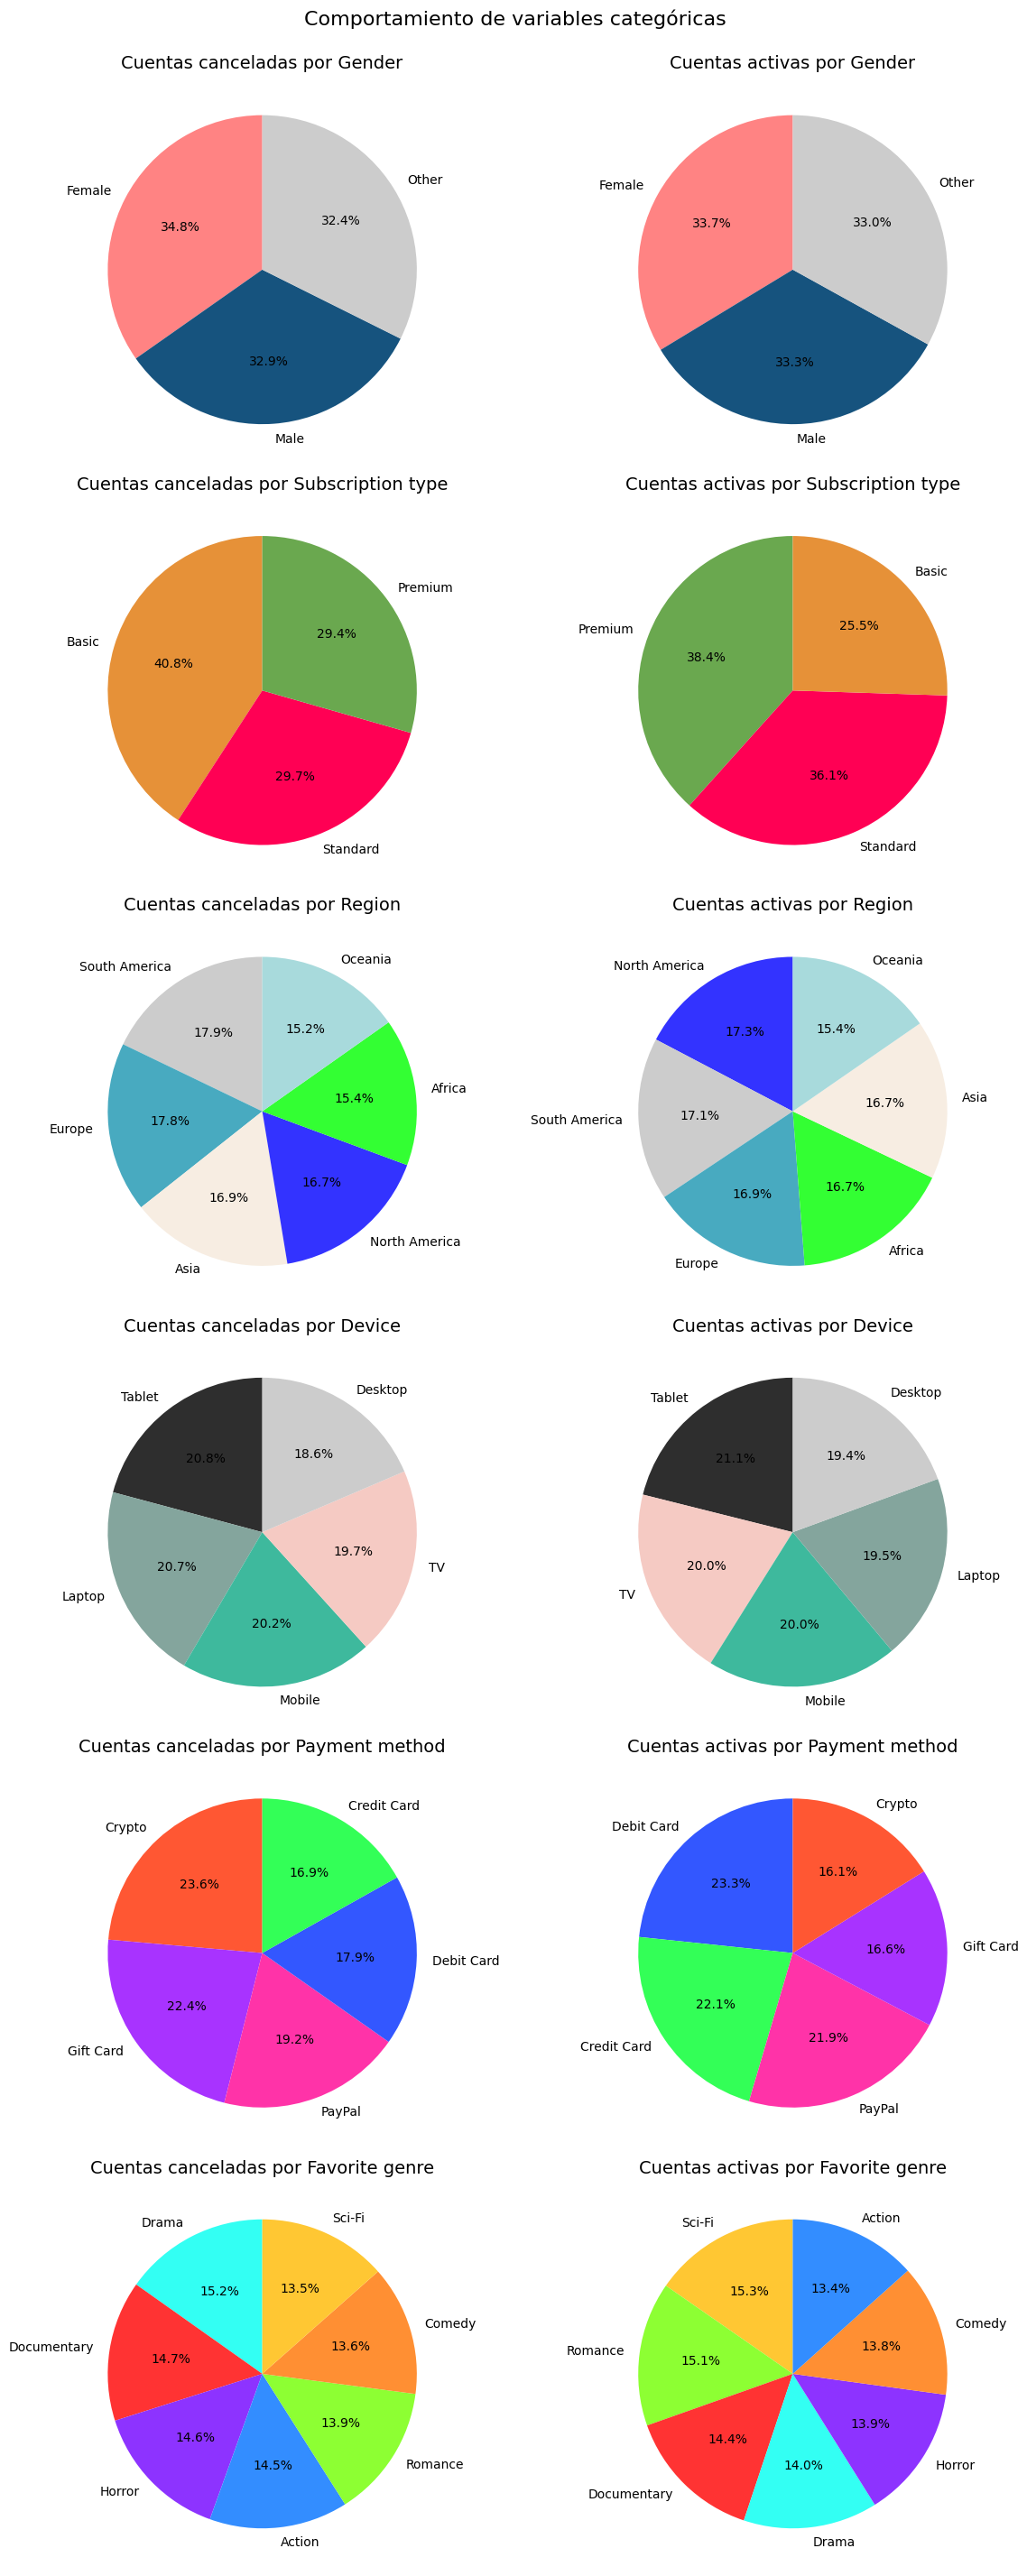

In [31]:
graficar_categoricas(datos,categorical_cols[1:])


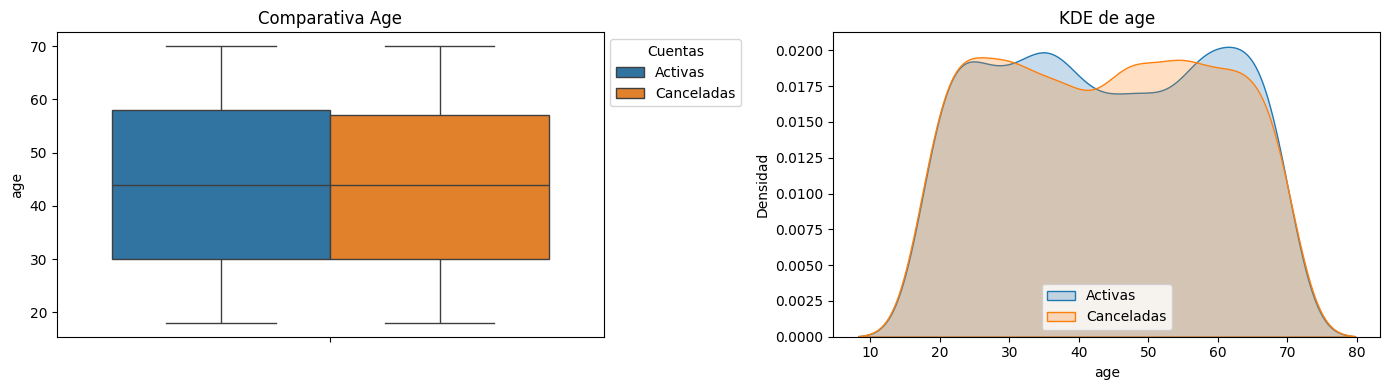

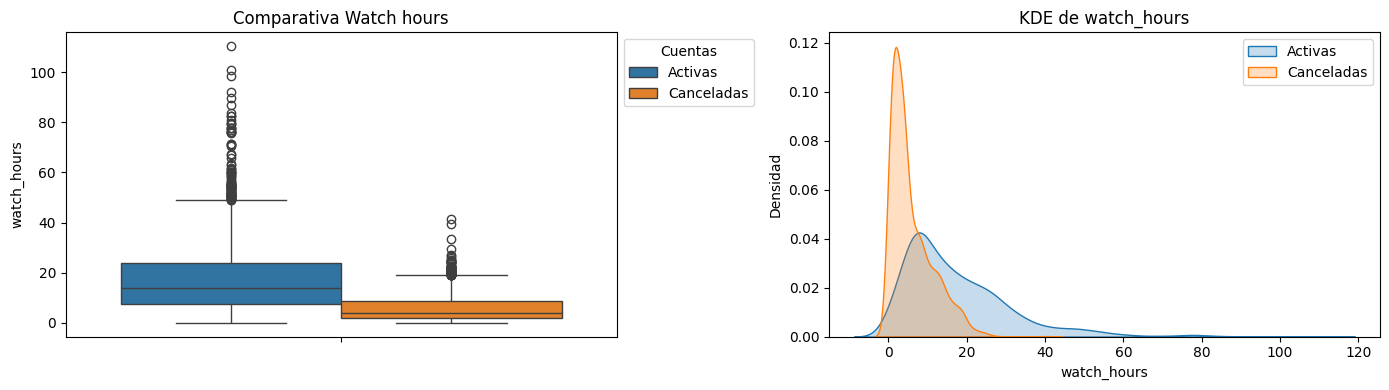

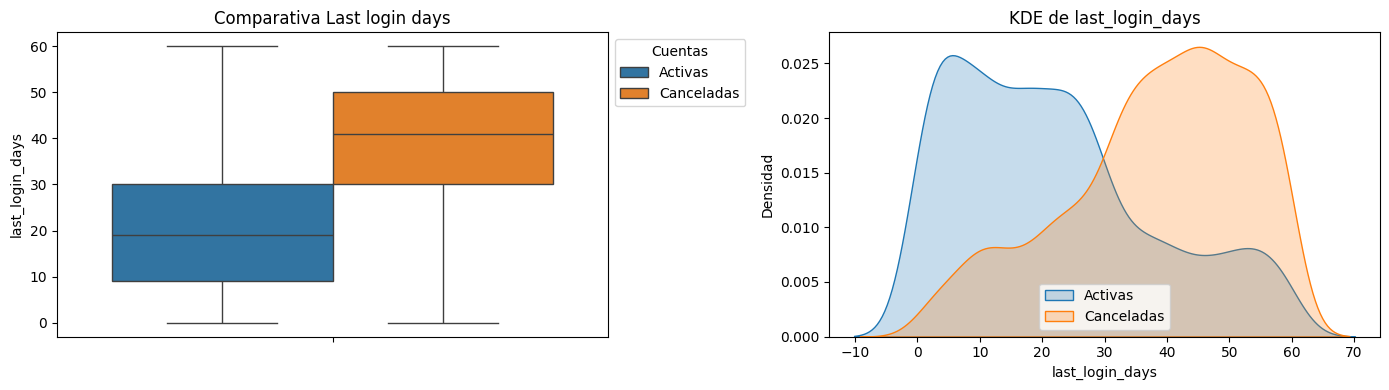

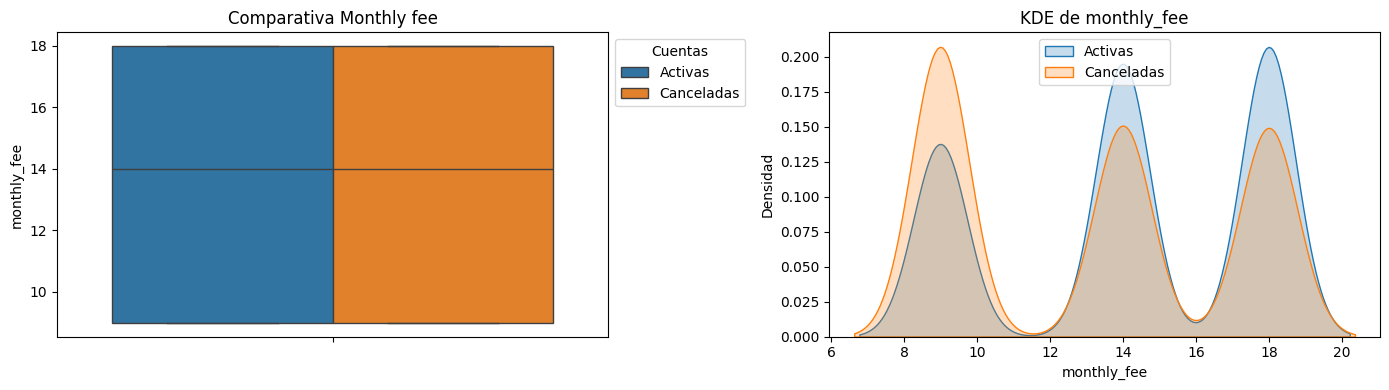

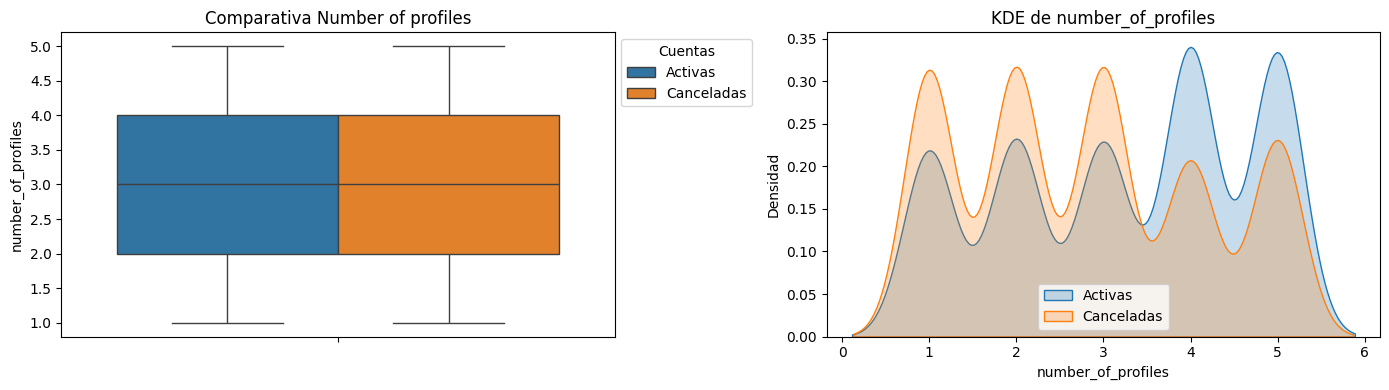

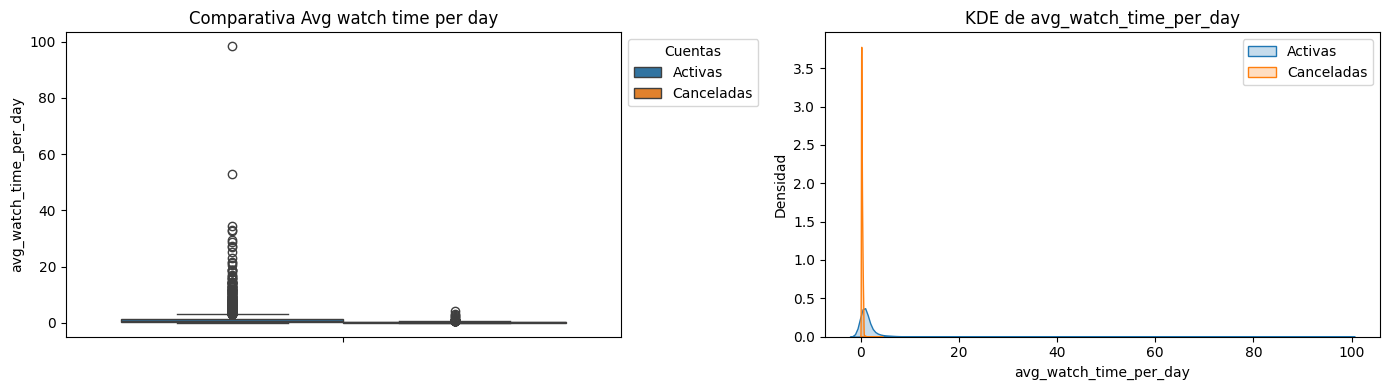

In [22]:
graficar_numericas(datos,numeric_cols)

In [23]:
numeric_cols

Index(['age', 'watch_hours', 'last_login_days', 'monthly_fee', 'churned',
       'number_of_profiles', 'avg_watch_time_per_day'],
      dtype='object')